In [2]:
!pip install iterative-stratification albumentations timm

In [1]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import tensorflow as tf
from fastai.vision.all import *
from fastai.callback.all import *
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import gc
import albumentations
from albumentations.pytorch import ToTensorV2
import warnings
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import timm
import shutil
from sklearn.utils.class_weight import compute_class_weight

2025-03-03 22:39:52.746596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741016392.885062 3580222 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741016392.935016 3580222 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-03 22:39:53.311672: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ptariya/miniconda3/envs/pt-jupyter/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Pleas

In [2]:
config = {
    'seed': 3407,
    'use_cuda': True,
    'image_size': 300,
    'batch_size': 64,
    'num_workers': 4,
    'num_folds': 5,
    'model_name': 'timm/tf_efficientnetv2_s.in21k_ft_in1k',
    'mixed_precision' : True,
    'augmentation_type': None,  # or 'cutmix','cutout',None
#     'fine_tune_epochs': 5,
    'fit_one_cycle_epochs': 10,
    'learning_rate': 1e-4,
    'train_csv_path': '/home/ptariya/deep-learning/train_data.csv',
    'test_csv_path': '/home/ptariya/deep-learning/test_data.csv',
    'train_image_path' : '/home/ptariya/deep-learning/data',
    'test_image_path' : '/home/ptariya/deep-learning/data',
    'output_csv_path': None,
    'output_csv_confidence_path': None, # For Pesudo Label
    'num_gpus': torch.cuda.device_count()  # Use all available GPUs
}

In [4]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    random.seed(seed_value)
    if use_cuda:
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

random_seed(config['seed'], config['use_cuda'])

## train test split to csv for inference supervised model

In [4]:
from sklearn.model_selection import train_test_split

image_paths = []
labels = []

dataset = '/home/ptariya/deep-learning/data'

for folder_name in os.listdir(dataset):
    folder_path = os.path.join(dataset, folder_name)

    if os.path.isdir(folder_path):
        images = [img for img in os.listdir(folder_path) if img.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for image_name in images:
            image_path = os.path.join(folder_path, image_name)
            image_paths.append(image_path)
            labels.append(folder_name)

data = {
    'image_path': image_paths,
    'label': labels
}
df = pd.DataFrame(data)

# Split the data into training and testing sets (80% train, 20% test)
train_daf, test_daf = train_test_split(df, test_size=0.25, stratify=df['label'], random_state=42)

# File paths to save the CSV files
train_csv_file_path = '/home/ptariya/deep-learning/train_data.csv'
test_csv_file_path = '/home/ptariya/deep-learning/test_data.csv'

# Save the training and testing DataFrames to separate CSV files
train_daf.to_csv(train_csv_file_path, index=False)
test_daf.to_csv(test_csv_file_path, index=False)

print(f'Training DataFrame saved to {train_csv_file_path}')
print(f'Test DataFrame saved to {test_csv_file_path}')


Training DataFrame saved to /home/ptariya/deep-learning/train_data.csv
Test DataFrame saved to /home/ptariya/deep-learning/test_data.csv


In [5]:
train_df = pd.read_csv(config['train_csv_path'])
train_df['image_path'] = train_df['image_path'].apply(lambda x : x)
train_df

,image_path,label
0,/home/ptariya/deep-learning/data/AluCan/alucan_s1b_386.jpg,AluCan
1,/home/ptariya/deep-learning/data/AluCan/alucan_s1b_364.jpg,AluCan
2,/home/ptariya/deep-learning/data/HDPEM/bottle (1009).jpg,HDPEM
3,/home/ptariya/deep-learning/data/AluCan/AluCan445.jpg,AluCan
4,"/home/ptariya/deep-learning/data/PET/PET1,179.jpg",PET
...,...,...
4528,/home/ptariya/deep-learning/data/PET/PET562.jpg,PET
4529,/home/ptariya/deep-learning/data/PET/PET298.jpg,PET
4530,"/home/ptariya/deep-learning/data/AluCan/AluCan1,062.jpg",AluCan
4531,/home/ptariya/deep-learning/data/Glass/Glass856.JPG,Glass


<Axes: xlabel='label'>

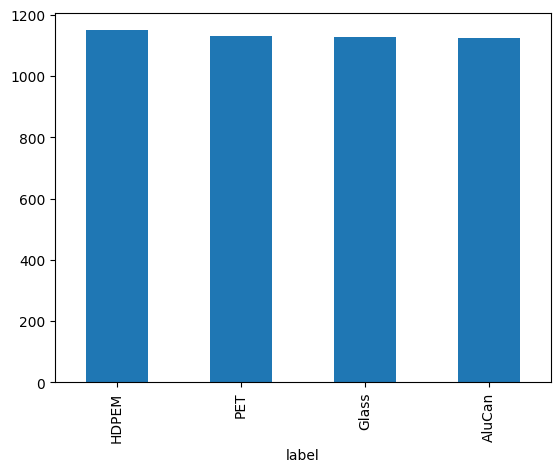

In [6]:
train_df.label.value_counts().plot.bar()

In [7]:
strat_kfold = MultilabelStratifiedKFold(n_splits=config['num_folds'], random_state=config['seed'], shuffle=True)
train_df['fold'] = -1
for i, (_, test_index) in enumerate(strat_kfold.split(train_df.image_path.values, train_df.iloc[:,1:].values)):
    train_df.iloc[test_index, -1] = i
    
train_df.head()

,image_path,label,fold
0,/home/ptariya/deep-learning/data/AluCan/alucan_s1b_386.jpg,AluCan,3
1,/home/ptariya/deep-learning/data/AluCan/alucan_s1b_364.jpg,AluCan,3
2,/home/ptariya/deep-learning/data/HDPEM/bottle (1009).jpg,HDPEM,3
3,/home/ptariya/deep-learning/data/AluCan/AluCan445.jpg,AluCan,0
4,"/home/ptariya/deep-learning/data/PET/PET1,179.jpg",PET,3


<Axes: xlabel='fold'>

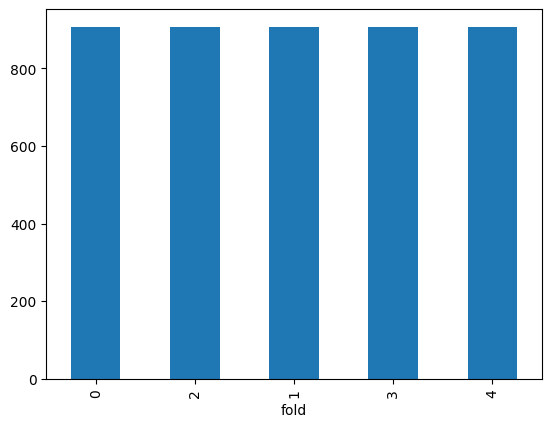

In [8]:
train_df.fold.value_counts().plot.bar()

In [9]:
class_labels = train_df['label'].values
classes = np.unique(class_labels)
class_weights = compute_class_weight('balanced', classes=classes, y=class_labels)
class_weights_dict = {cls: weight for cls, weight in zip(classes, class_weights)}

# Define custom loss function with class weights
def weighted_loss(pred, target):
    weights_tensor = torch.tensor([class_weights_dict[cls] for cls in dls.vocab]).float().to('cuda')
    return F.cross_entropy(pred, target, weight=weights_tensor)

# Data Augmentation

In [10]:
class AlbumentationsTransform(RandTransform):
    split_idx, order = None, 2
    def __init__(self, train_aug, valid_aug): 
        super().__init__()
        store_attr()

    def before_call(self, b, split_idx):
        self.idx = split_idx

    def encodes(self, img: PILImage):
        if self.idx == 0:
            aug_img = self.train_aug(image=np.array(img))['image']
        else:
            aug_img = self.valid_aug(image=np.array(img))['image']
            
        aug_img = aug_img.astype(np.uint8)
        return PILImage.create(aug_img)

In [35]:
warnings.filterwarnings('ignore')

size = config['image_size']
def get_train_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
            #AutoContrast(),
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None), #Extra tip, use size that's suitable for the efficentNetwork you are using.
            albumentations.Rotate(limit=(-20, 20)),
#             albumentations.HorizontalFlip(p=0.5),
#             albumentations.VerticalFlip(p=0.5),
            #albumentations.Sharpen(always_apply=False, p=1.0, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
            #albumentations.GaussianBlur(always_apply=False, p=1.0, blur_limit=(3, 7), sigma_limit=(0.0, 0)),
            # #albumentations.ShiftScaleRotate(always_apply=False, p=1.0, shift_limit_x=(-0.06, 0.06), shift_limit_y=(-0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-20, 20), interpolation=0, border_mode=0, value=(255, 255, 255), mask_value=None, rotate_method='largest_box'),
            # albumentations.HueSaturationValue(
            #     hue_shift_limit=0.2, 
            #     sat_shift_limit=0.2, 
            #     val_shift_limit=0.2, 
            #     p=0.5
            # ),
            # #albumentations.ColorJitter(contrast=(0.9, 1.1)),
            # #albumentations.CLAHE(always_apply=False, p=0.5, clip_limit=(1, 4), tile_grid_size=(8, 8)),
            # albumentations.RandomBrightnessContrast(
            #     brightness_limit=(-0.2,0.2), 
            #     contrast_limit=(-0.2, 0.2), 
            #     p=0.5
            # ),
            #albumentations.RandomGamma(),
            albumentations.ToGray(always_apply=False, p=1.0)
            
           #albumentations.RandomGridShuffle(p=0.5)\
    ], p=1.0)



def get_valid_aug(): return albumentations.Compose([
            albumentations.Resize(always_apply=False, p=1.0, height=size, width=size, interpolation=0),
  
            #albumentations.PadIfNeeded(always_apply=False, p=1.0, min_height=size, min_width=size, pad_height_divisor=None, pad_width_divisor=None, border_mode=0, value=(255, 255, 255), mask_value=None),
            #albumentations.ToGray(always_apply=False, p=1.0),
            #AutoContrast(),
             
            ], p=1.0)

item_tfms = AlbumentationsTransform(get_train_aug(), get_valid_aug())
batch_tfms = [Normalize.from_stats(*imagenet_stats)]

In [36]:
def get_data(fold=0):
    return DataBlock(
        blocks=(ImageBlock, CategoryBlock),
        get_x=ColReader(0),
        get_y=ColReader(1),
        splitter=IndexSplitter(train_df[train_df.fold == fold].index),
        item_tfms=[AlbumentationsTransform(get_train_aug(), get_train_aug())],
        batch_tfms=[Normalize.from_stats(*imagenet_stats)]
    ).dataloaders(train_df, bs=config['batch_size'], num_workers=config['num_workers'])

In [14]:
test_df = pd.read_csv(config['test_csv_path'])
test_df['image_path'] = test_df['image_path'].apply(lambda x : x )
tstpng = test_df.copy()
tstpng.head()

,image_path,label
0,/home/ptariya/deep-learning/data/HDPEM/HDPEM772.JPG,HDPEM
1,/home/ptariya/deep-learning/data/AluCan/AluCan733.jpg,AluCan
2,/home/ptariya/deep-learning/data/AluCan/AluCan916.jpg,AluCan
3,/home/ptariya/deep-learning/data/AluCan/AluCan505.jpg,AluCan
4,/home/ptariya/deep-learning/data/HDPEM/HDPEM966.JPG,HDPEM


In [39]:
def create_model(model_name, num_classes):
    model = timm.create_model(model_name, pretrained=True, num_classes=num_classes)
    if config['num_gpus'] > 1:
        model = nn.DataParallel(model)
    return model

In [37]:
def get_augmentation_callback(augmentation_type, alpha=1.0, cutout_size=8):
    if augmentation_type == 'mixup':
        return MixUp(alpha=alpha)
    elif augmentation_type == 'cutmix':
        return CutMix(alpha=alpha)
    elif augmentation_type == 'cutout':
        # Return a callback that applies CutOut
        return aug_transforms(cutout=cutout_size)
    else:
        return None

In [40]:
all_preds = []
best_model_path = f'/home/ptariya/deep-learning/results/models/best_model_effnetv2-v2.pth'

for i in range(config['num_folds']):
    dls = get_data(i)
    model = create_model(config['model_name'], num_classes=len(dls.vocab))
    augmentation_callback = get_augmentation_callback(config['augmentation_type'])
    learn = Learner(
        dls, model,
        loss_func=weighted_loss,
        metrics=[accuracy],
        cbs=[SaveModelCallback(monitor='valid_loss', fname=f'best_model_fold_{i}')]
    )
    
    if config['mixed_precision']:
        learn = learn.to_fp16()
    
    learn.model = learn.model.to('cuda')
    torch.cuda.empty_cache()
    
    learn.fit_one_cycle(config['fit_one_cycle_epochs'], lr_max=config['learning_rate'], cbs=[EarlyStoppingCallback(monitor='valid_loss')])
    
    torch.cuda.empty_cache()
    
    tst_dl = learn.dls.test_dl(tstpng)
    preds, _ = learn.get_preds(dl=tst_dl)
    all_preds.append(preds)
    
    torch.save(learn.model.state_dict(), best_model_path)
    # Track the best model based on validation loss
    # valid_loss = learn.recorder.values[-1][0] if learn.recorder.values and learn.recorder.values[-1][0] is not None else float('inf')

    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(learn.model.state_dict(), best_model_path)
    
    del learn
    torch.cuda.empty_cache()
    gc.collect()
    
print('Training Completed')


epoch,train_loss,valid_loss,accuracy,time
0,4.352128,1.346125,0.712238,00:52
1,1.453506,0.281010,0.923925,00:52
2,0.520743,0.230409,0.945976,00:51
3,0.194511,0.150332,0.959206,00:51
4,0.084292,0.150136,0.965821,00:52
5,0.039530,0.124318,0.970232,00:52
6,0.019645,0.118249,0.972437,00:51
7,0.013784,0.110989,0.976847,00:51
8,0.010331,0.104297,0.977949,00:52
9,0.009451,0.101998,0.976847,00:59


Better model found at epoch 0 with valid_loss value: 1.3461252450942993.
Better model found at epoch 1 with valid_loss value: 0.28101009130477905.
Better model found at epoch 2 with valid_loss value: 0.23040887713432312.
Better model found at epoch 3 with valid_loss value: 0.15033207833766937.
Better model found at epoch 4 with valid_loss value: 0.15013551712036133.
Better model found at epoch 5 with valid_loss value: 0.12431778758764267.
Better model found at epoch 6 with valid_loss value: 0.11824910342693329.
Better model found at epoch 7 with valid_loss value: 0.11098930984735489.
Better model found at epoch 8 with valid_loss value: 0.10429684072732925.
Better model found at epoch 9 with valid_loss value: 0.10199839621782303.


epoch,train_loss,valid_loss,accuracy,time
0,4.632073,1.543007,0.676957,00:52
1,1.523020,0.313315,0.927233,00:51
2,0.552104,0.172089,0.950386,00:52
3,0.219403,0.129167,0.959206,00:52
4,0.095289,0.099818,0.971334,00:52
5,0.047564,0.081329,0.970232,00:52
6,0.023036,0.090247,0.973539,00:52


Better model found at epoch 0 with valid_loss value: 1.5430073738098145.
Better model found at epoch 1 with valid_loss value: 0.31331536173820496.
Better model found at epoch 2 with valid_loss value: 0.1720891296863556.
Better model found at epoch 3 with valid_loss value: 0.12916697561740875.
Better model found at epoch 4 with valid_loss value: 0.09981779754161835.
Better model found at epoch 5 with valid_loss value: 0.08132927864789963.
No improvement since epoch 5: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,4.185783,1.522424,0.707828,00:52
1,1.438197,0.316138,0.911797,00:52
2,0.539998,0.188496,0.953694,00:52
3,0.215093,0.106564,0.970232,00:52
4,0.092002,0.110188,0.970232,00:52


Better model found at epoch 0 with valid_loss value: 1.5224236249923706.
Better model found at epoch 1 with valid_loss value: 0.3161375820636749.
Better model found at epoch 2 with valid_loss value: 0.18849600851535797.
Better model found at epoch 3 with valid_loss value: 0.10656380653381348.
No improvement since epoch 3: early stopping


epoch,train_loss,valid_loss,accuracy,time
0,4.639933,1.502862,0.704194,00:52
1,1.545818,0.280916,0.921634,00:52
2,0.545145,0.148469,0.950331,00:52
3,0.209528,0.100059,0.965784,00:52
4,0.086546,0.086768,0.972406,00:52
5,0.045267,0.080562,0.976821,00:52
6,0.025538,0.076917,0.974614,00:52
7,0.014990,0.070809,0.977925,00:52
8,0.011458,0.069060,0.976821,00:53
9,0.009455,0.066206,0.977925,00:52


Better model found at epoch 0 with valid_loss value: 1.5028620958328247.
Better model found at epoch 1 with valid_loss value: 0.28091588616371155.
Better model found at epoch 2 with valid_loss value: 0.14846935868263245.
Better model found at epoch 3 with valid_loss value: 0.10005923360586166.
Better model found at epoch 4 with valid_loss value: 0.0867677703499794.
Better model found at epoch 5 with valid_loss value: 0.08056160807609558.
Better model found at epoch 6 with valid_loss value: 0.0769166648387909.
Better model found at epoch 7 with valid_loss value: 0.07080855965614319.
Better model found at epoch 8 with valid_loss value: 0.06906025111675262.
Better model found at epoch 9 with valid_loss value: 0.06620554625988007.


epoch,train_loss,valid_loss,accuracy,time
0,3.905074,1.571390,0.685430,00:51
1,1.314060,0.335214,0.922737,00:51
2,0.484069,0.226809,0.950331,00:52
3,0.191637,0.163998,0.959161,00:52
4,0.080484,0.155863,0.961369,00:52
5,0.038345,0.136176,0.972406,00:52
6,0.022388,0.134581,0.970199,00:52
7,0.014359,0.119897,0.976821,00:52
8,0.010895,0.111650,0.976821,00:52
9,0.008676,0.115838,0.976821,00:52


Better model found at epoch 0 with valid_loss value: 1.5713902711868286.
Better model found at epoch 1 with valid_loss value: 0.3352135419845581.
Better model found at epoch 2 with valid_loss value: 0.22680935263633728.
Better model found at epoch 3 with valid_loss value: 0.1639980673789978.
Better model found at epoch 4 with valid_loss value: 0.15586315095424652.
Better model found at epoch 5 with valid_loss value: 0.13617637753486633.
Better model found at epoch 6 with valid_loss value: 0.13458138704299927.
Better model found at epoch 7 with valid_loss value: 0.11989664286375046.
Better model found at epoch 8 with valid_loss value: 0.11165016889572144.
No improvement since epoch 8: early stopping


Training Completed


## Prediction and Submission

In [41]:
sub = pd.read_csv(config['test_csv_path'])
preds = np.mean(np.stack(all_preds), axis=0)
preds = torch.from_numpy(preds)
preds

tensor([[ -1.7103,  -3.4172,  10.3328,  -7.8496],
        [  5.8091,  -7.1758,  -9.3270,  -3.5771],
        [  9.1678,  -7.6119,  -5.5360,   1.0576],
        ...,
        [-13.3773,  -0.6750,  -5.5443,  13.3984],
        [ 11.5891,  -1.2459,  -4.2338,  -2.1277],
        [ -4.1428,  -2.8496,  -6.0539,   9.4563]])

In [42]:
idxs = preds.argmax(dim=1)
confidences, _ = torch.max(preds, dim=1)
vocab = np.array(dls.vocab)

sub['predict'] = vocab[idxs]
sub

,image_path,label,predict
0,/home/ptariya/deep-learning/data/HDPEM/HDPEM772.JPG,HDPEM,HDPEM
1,/home/ptariya/deep-learning/data/AluCan/AluCan733.jpg,AluCan,AluCan
2,/home/ptariya/deep-learning/data/AluCan/AluCan916.jpg,AluCan,AluCan
3,/home/ptariya/deep-learning/data/AluCan/AluCan505.jpg,AluCan,AluCan
4,/home/ptariya/deep-learning/data/HDPEM/HDPEM966.JPG,HDPEM,HDPEM
...,...,...,...
1506,/home/ptariya/deep-learning/data/HDPEM/HDPEM453.jpg,HDPEM,HDPEM
1507,"/home/ptariya/deep-learning/data/PET/PET1,394.jpg",PET,PET
1508,/home/ptariya/deep-learning/data/PET/PET634.jpg,PET,PET
1509,/home/ptariya/deep-learning/data/AluCan/alucan_s1b_255.jpg,AluCan,AluCan


Total predictions: 1511
Correct predictions: 1504
Accuracy: 99.54%

Classification Report:
              precision    recall  f1-score   support

      AluCan       0.99      1.00      0.99       375
       Glass       0.99      0.99      0.99       376
       HDPEM       1.00      1.00      1.00       383
         PET       0.99      0.99      0.99       377

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511



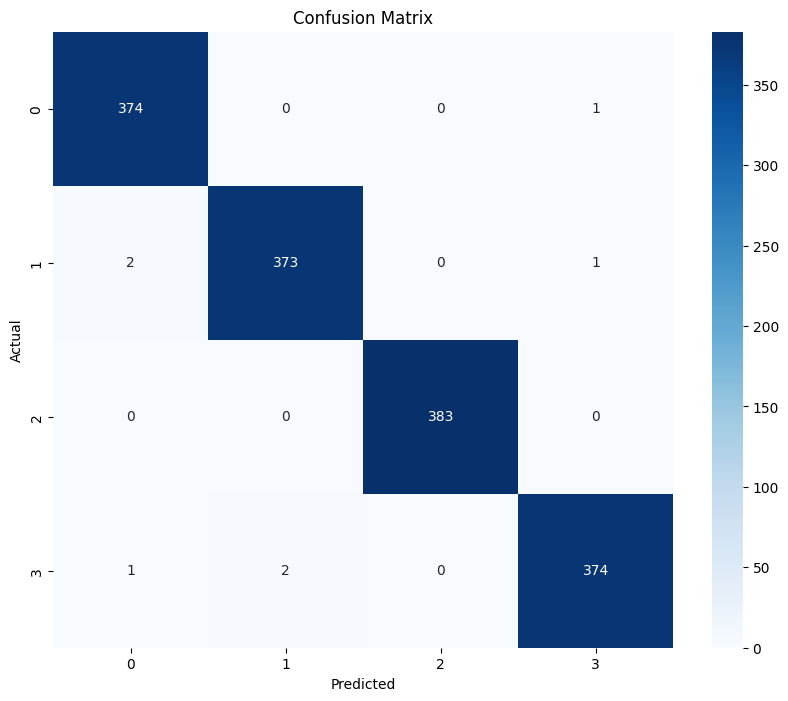

In [43]:
# Calculate total number of predictions
total_predictions = len(sub)

# Calculate number of correct predictions
correct_predictions = (sub['label'] == sub['predict']).sum()

# Calculate accuracy
res_accuracy = correct_predictions / total_predictions

# Generate a classification report
from sklearn.metrics import classification_report
report = classification_report(sub['label'], sub['predict'])

# Print results
print(f"Total predictions: {total_predictions}")
print(f"Correct predictions: {correct_predictions}")
print(f"Accuracy: {res_accuracy:.2%}")
print("\nClassification Report:")
print(report)

# Optional: Generate confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(sub['label'], sub['predict'])
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
import torch
from torchvision import transforms
import time

def create_model(num_classes):
    model = timm.create_model("tf_efficientnetv2_s.in21k_ft_in1k", pretrained=False, num_classes=num_classes)
    return model

def load_best_model(model_path, num_classes, device="cuda" if torch.cuda.is_available() else "cpu"):
    model = create_model(num_classes).to(device)
    
    state_dict = torch.load(model_path, map_location=device)  # Load with device mapping
    
    model.load_state_dict(state_dict)  # Ensure all keys match
    model.eval()
    
    return model

def predict(image_path, model_path, class_names):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = load_best_model(model_path, len(class_names), device)
    
    transform = transforms.Compose([
        transforms.Resize(380),  
        transforms.CenterCrop(380),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        transforms.Grayscale(num_output_channels=3)
    ])
    
    img = Image.open(image_path).convert('RGB')
    img_tensor = transform(img).unsqueeze(0).to(device)
    
    start_time = time.time()
    
    with torch.no_grad():
        output = model(img_tensor)
        probabilities = torch.nn.functional.softmax(output, dim=1)
        predicted_class_index = probabilities.argmax().item()
        predicted_class = class_names[predicted_class_index]
    
    end_time = time.time()
    inference_time = end_time - start_time 
    print(f"Inference time: {inference_time:.6f} seconds")  
    
    return predicted_class, probabilities[0].tolist()

def display_probabilities(class_names, probabilities):
    # Sort probabilities in descending order
    sorted_probs = sorted(zip(class_names, probabilities), key=lambda x: x[1], reverse=True)
    
    print("Class Probabilities:")
    print("-------------------")
    for class_name, prob in sorted_probs:
        print(f"{class_name:<15} : {prob:.4f} ({prob*100:.2f}%)")

In [72]:
image_path = '/home/ptariya/deep-learning/coca-cola-drink-aluminium-can-3d-model-298126.webp'
model_path = '/home/ptariya/deep-learning/results/models/best_model_effnetv2-v2.pth'
class_names = ['AluCan', 'Glass', 'HDPEM', 'PET']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predicted_class, probabilities = predict(image_path, model_path, class_names)
print(f"Predicted class: {predicted_class}")
print()
display_probabilities(class_names, probabilities)

Inference time: 0.014402 seconds
Predicted class: AluCan

Class Probabilities:
-------------------
AluCan          : 1.0000 (100.00%)
Glass           : 0.0000 (0.00%)
HDPEM           : 0.0000 (0.00%)
PET             : 0.0000 (0.00%)


In [73]:
image_path = '/home/ptariya/deep-learning/coca-cola-drink-aluminium-can-3d-model-298126.webp'
model_path = '/home/ptariya/deep-learning/results/models/best_model_effnetv2.pth'
class_names = ['AluCan', 'Glass', 'HDPEM', 'PET']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

predicted_class, probabilities = predict(image_path, model_path, class_names)
print(f"Predicted class: {predicted_class}")
print()
display_probabilities(class_names, probabilities)

Inference time: 0.014314 seconds
Predicted class: AluCan

Class Probabilities:
-------------------
AluCan          : 0.9963 (99.63%)
Glass           : 0.0036 (0.36%)
HDPEM           : 0.0000 (0.00%)
PET             : 0.0000 (0.00%)
